# Diversity Loss

Neurons are often polysemantic, which means that a single neuron may be activated by several different features. With visualization via optimization, we may have no control over which feature we are optimizing for. The resulting visualization might contain a single feature or a mixture of different features.

To remedy this, the authors of the original Lucid library came up with a Diversity objective, which is also explored in the [Feature Visualization](https://distill.pub/2017/feature-visualization/#diversity) article. The main idea behind the Diversity objective is to minimize pairwise cosine similarities between the Gram matrix representations of each image in a batch. This is similar to the style similarity concept from [style transfer](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf).

The `optim.captum` library also contains the similar `Diversity` loss which can be used in the same fashion, to help tease out different features that activate a single neuron.

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision

import captum.optim as opt
from captum.optim.models import googlenet

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = googlenet(pretrained=True).to(device)

In [2]:
# Helper functions for visualizations
def visualize(model, image, loss_fn, lr=0.025):
    transforms = [
        torch.nn.ReflectionPad2d(16),
        opt.transform.RandomSpatialJitter(16),
        opt.transform.RandomScale(scale=(1, 0.975, 1.025, 0.95, 1.05)),
        torchvision.transforms.RandomRotation(degrees=(-5,5)),
        opt.transform.RandomSpatialJitter(8),
        opt.transform.CenterCrop((224,224)),
    ]
    if not isinstance(model, opt.models.InceptionV1):
        transforms = [torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        )] + transforms
    transforms = torch.nn.Sequential(*transforms)
    obj = opt.InputOptimization(model, loss_fn, image, transforms, lr=lr)
    history = obj.optimize()
    image().show(figsize=(10, 10))

This neuron seems to be activated by different types of balls from different sports.

  0%|          | 0/512 [00:00<?, ? step/s]

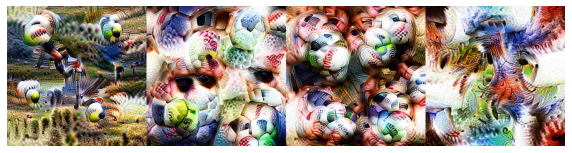

In [3]:
image = opt.images.NaturalImage((224, 224), batch=4).to(device)
loss_fn = sum([
    opt.loss.ChannelActivation(model.mixed5a, 9),
    1e2*opt.loss.Diversity(model.mixed5a),
])
visualize(model, image, loss_fn)

Activated by different types of curves.

  0%|          | 0/512 [00:00<?, ? step/s]

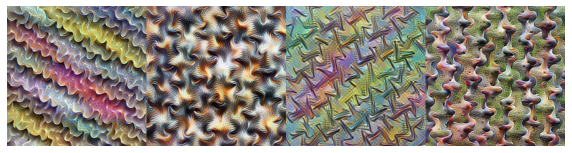

In [4]:
image = opt.images.NaturalImage((224, 224), batch=4).to(device)
loss_fn = sum([
    opt.loss.ChannelActivation(model.mixed4a, 97),
    1e3*opt.loss.Diversity(model.mixed4a),
])
visualize(model, image, loss_fn)

This neuron is activated by a brown fur-like texture from different directions.

  0%|          | 0/512 [00:00<?, ? step/s]

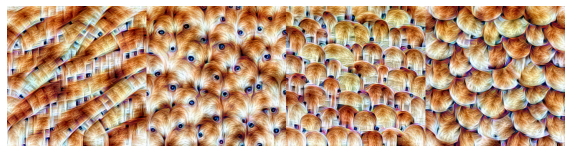

In [5]:
image = opt.images.NaturalImage((224, 224), batch=4).to(device)
loss_fn = sum([
    opt.loss.ChannelActivation(model.mixed4a, 143),
    1e2*opt.loss.Diversity(model.mixed4a),
])
visualize(model, image, loss_fn)

A neuron can also be activated by very different features, such as cats versus cars.

  0%|          | 0/512 [00:00<?, ? step/s]

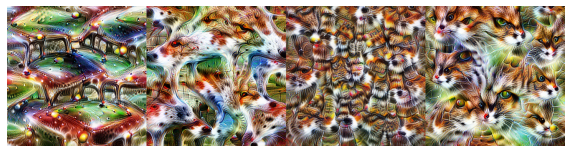

In [6]:
image = opt.images.NaturalImage((224, 224), batch=4).to(device)
loss_fn = sum([
    opt.loss.ChannelActivation(model.mixed4e, 55),
    1e2*opt.loss.Diversity(model.mixed4e),
])
visualize(model, image, loss_fn)